In [23]:
from src.utils.results_utils import *
import pandas as pd
from jellyfish import soundex
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ethnicity model

In [24]:
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity.sample(10)

,Name,Country
4325,Vera,Slavic
2772,Georg,Germanic
1895,Nicola,Romance
427,Walter,Germanic
9403,Marjorie,English-Speaking
2949,Frantisek,Slavic
6649,Uwe,Germanic
5297,Affonso,Hispanic
7428,Frank,English-Speaking
7125,Eric,Romance


In [25]:
df_ethnicity['Country'].value_counts()

Country
English-Speaking    2812
Germanic            2359
Romance             1847
Slavic              1587
Hispanic             891
Nordic               882
East Asian           673
Name: count, dtype: int64

In [26]:
def find_unusual_characters(df, column_name, allowed_chars='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    """
    Identify all unique characters in a column that are not in the allowed characters.

    Parameters:
        df (pd.DataFrame): The dataset containing the column.
        column_name (str): The name of the column to analyze.
        allowed_chars (str): A string of allowed characters.

    Returns:
        set: A set of unique unusual characters.
    """
    # Create a set of allowed characters
    allowed_set = set(allowed_chars)
    
    # Combine all characters in the specified column
    all_characters = ''.join(df[column_name].dropna().astype(str))
    
    # Find unusual characters
    unusual_characters = set(all_characters) - allowed_set
    
    # Print and return the unusual characters
    print("Unusual Characters Found:", unusual_characters)

find_unusual_characters(df_ethnicity, 'Name')

Unusual Characters Found: {'Ö', 'ë', 'è', 'Ã', 'á', 'é', '¶', 'ö', 'ç', 'ä', '©', 'ü', 'ï'}


Encode the Coutries as numbers :

In [27]:
class ColumnEncoder:
    def __init__(self, column_name):
        """
        Initialize the encoder for a specific column.
        """
        self.column_name = column_name
        self.legend = None  # To store the legend of encoded values

    def fit_transform(self, df):
        """
        Encodes the column in the DataFrame as integers and stores the legend.
        """
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        # Factorize the column and store the legend
        df[self.column_name], self.legend = pd.factorize(df[self.column_name])
        return df

    def get_legend(self):
        """
        Generates a DataFrame containing the legend of encoded values.
        """
        if self.legend is None:
            raise ValueError("The encoder has not been fitted. Call `fit_transform` first.")
        
        legend_df = pd.DataFrame({
            'Encoded Value': range(len(self.legend)),
            self.column_name: self.legend
        })
        return legend_df

In [28]:
# Encode the column in the DataFrame
encoder = ColumnEncoder(column_name='Country')
df_ethnicity = encoder.fit_transform(df_ethnicity)

# Get the legend 
legend_df = encoder.get_legend()
print("Legend:")
legend_df.head(14)


Legend:


,Encoded Value,Country
0,0,Slavic
1,1,Nordic
2,2,Romance
3,3,East Asian
4,4,Germanic
5,5,English-Speaking
6,6,Hispanic


In [29]:
df_ethnicity.sample(10)

,Name,Country
1897,Richard,5
1584,Michiko,3
9566,Jonder,6
10082,Werner,4
5582,Christine,2
7118,Atanas,0
3028,Jenni,1
2810,Renato,2
9194,Dan,1
5786,Stefanie,4


## 1. Name Lenght, Vowel/Consonant Count and Ratio, Soundex and N-Gram

In [30]:
class EthnicityDataProcessor:
    def __init__(self, ngram_range=(2, 3)):
        """
        Initialize the processor with optional n-gram range for text vectorization.
        """
        self.ngram_range = ngram_range
        self.vectorizer = None

    @staticmethod
    def analyze_name(name):
        if not isinstance(name, str) or not name.strip():  # Handle empty or invalid names
            return pd.Series({
                'Length': 0,  
                'Vowel Count': 0,
                'Consonant Count': 0,
                'Vowel/Consonant Ratio': 0,
            })

        vowels = set('aeiouy')
        consonants = set('bcdfghjklmnpqrstvwxz')
        length = len(name)
        vowel_count = sum(1 for char in name.lower() if char in vowels)
        consonant_count = sum(1 for char in name.lower() if char in consonants)
        return pd.Series({
            'Length': length,
            'Vowel Count': vowel_count,
            'Consonant Count': consonant_count,
            'Vowel/Consonant Ratio': vowel_count / consonant_count if consonant_count > 0 else 0,
        })

    @staticmethod
    def add_diacritic_columns(names, diacritics="üéèäöÃëçÖïá"):
        """
        Add binary columns for each diacritic in the names.
        """
        diacritic_set = set(diacritics)
        diacritic_columns = {
            f"{diacritic}": names.apply(lambda name: 1 if diacritic in name.lower() else 0)
            for diacritic in diacritic_set
        }
        diacritic_df = pd.DataFrame(diacritic_columns)
        # Drop columns where no diacritics are found
        diacritic_df = diacritic_df.loc[:, (diacritic_df.sum(axis=0) > 0)]
        return diacritic_df

    # @staticmethod
    # def add_soundex_encoding(names):
    #     """
    #     Add Soundex encoding to the names.
    #     """
    #     soundex_series = names.apply(soundex)
    #     return pd.get_dummies(soundex_series, prefix='Soundex')

    def add_ngram_features(self, names):
        """
        Add n-gram features for the names using character-based n-grams.
        """
        if self.ngram_range is not None:
            self.vectorizer = CountVectorizer(analyzer='char', ngram_range=self.ngram_range)
            ngram_features = self.vectorizer.fit_transform(names)
            return pd.DataFrame(ngram_features.toarray(), columns=self.vectorizer.get_feature_names_out())
        return pd.DataFrame()

    def process(self, df):
        """
        Process the input DataFrame to add all the features.
        """
        # Analyze names
        df = df.join(df['Name'].apply(self.analyze_name))

        # Add diacritic columns
        diacritic_df = self.add_diacritic_columns(df['Name'])
        df = df.join(diacritic_df)

        # Add Soundex encoding
        # soundex_df = self.add_soundex_encoding(df['Name'])
        # df = pd.concat([df, soundex_df], axis=1)

        # Add n-gram features
        ngram_df = self.add_ngram_features(df['Name'])
        df = pd.concat([df, ngram_df], axis=1)

        return df

In [ ]:
# Process df_ethnicity
processor = EthnicityDataProcessor(ngram_range=(2, 3))
df_ethnicity_processed = processor.process(df_ethnicity)

df_ethnicity_processed.to_csv('preprocess.csv', index=False)

df_ethnicity_processed.head()

,Name,Country,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,ë,è,á,é,...,öt,öta,öte,öth,üd,üdi,ün,ünt,ür,ürg
0,Vaclav,0,6.0,2.0,4.0,0.50,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kristine,1,8.0,3.0,5.0,0.60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Matteo,2,6.0,3.0,3.0,1.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Isao,3,4.0,3.0,1.0,3.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Michael,4,7.0,3.0,4.0,0.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Par rapport à Soundex :** Phonetic algorithm designed to index words (particularly names) based on their pronunciation rather than their spelling. This is especially useful when trying to find names that sound similar but are spelled differently.

## 2. Scaling features and PCA

In [32]:
class PCAProcessor:
    def __init__(self, n_components=100):
        """
        Initialize the PCAProcessor with a specified number of components.
        """
        self.n_components = n_components
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.pca_features = None
        self.explained_variance_ratio_ = None

    def fit_transform(self, df, drop_columns=None):
        """
        Fit the PCA model and transform the input DataFrame.
        """
        # Drop specified columns if provided
        if drop_columns:
            df_features = df.drop(columns=drop_columns)
        else:
            df_features = df.copy()

        # Standardize the data
        features_scaled = self.scaler.fit_transform(df_features)

        # Apply PCA
        self.pca_features = self.pca.fit_transform(features_scaled)
        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_

        # Create a DataFrame for the PCA-transformed data
        pca_columns = [f'PC{i+1}' for i in range(self.n_components)]
        return pd.DataFrame(self.pca_features, columns=pca_columns, index=df.index)

    def plot_explained_variance(self):
        """
        Plot the cumulative explained variance by PCA components.
        """
        if self.explained_variance_ratio_ is None:
            raise ValueError("PCA has not been fitted. Run `fit_transform` first.")
        
        plt.figure(figsize=(8, 5))
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative Explained Variance by PCA Components")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.grid()
        plt.show()

    def merge_with_original(self, original_df, pca_df, keep_columns):
        """
        Merge the PCA-transformed DataFrame with the original DataFrame.
        """
        # Retain only specified columns and merge with PCA DataFrame
        merged_df = pd.concat([original_df[keep_columns], pca_df], axis=1)
        return merged_df

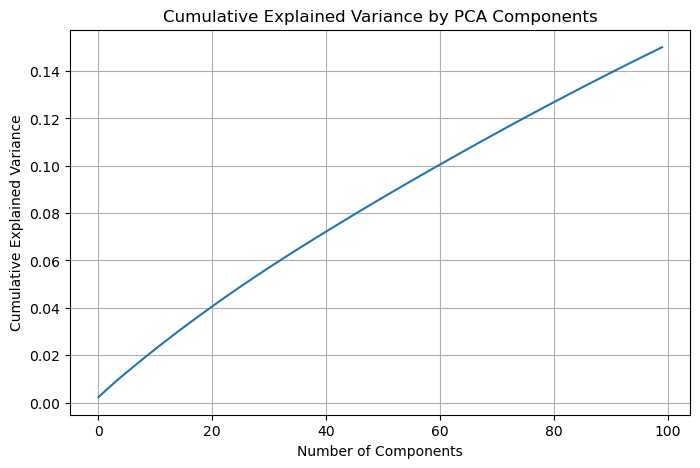

,Name,Country,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,Vaclav,0,-0.454013,-0.171138,0.513441,-1.526384,4.802906,-0.172229,1.738493,-0.040452,...,-0.000985,1.170581,0.519435,-1.074046,-1.615303,-0.585703,2.304050,1.659979,0.815597,-1.957742
1,Kristine,1,12.308161,6.064334,-1.991374,-1.641839,-1.213725,-0.387873,0.973894,1.024216,...,1.535751,0.579810,0.802031,1.389601,2.817082,-1.196687,-0.402096,0.381352,-0.256486,0.786252
2,Matteo,2,-0.464677,-0.275858,0.638150,-1.049339,-1.487110,-0.191854,-0.934515,0.017812,...,-0.533397,-1.142727,0.009983,-0.149005,-1.073759,0.128060,-0.475006,1.063781,-2.643232,1.274134
3,Isao,3,-0.540567,-0.267740,0.342651,-0.830543,-0.317454,-0.553383,0.430277,0.177419,...,-0.167985,-0.014807,0.461634,-0.231535,1.181980,-0.230696,0.774581,0.352219,0.400221,0.511401
4,Michael,4,1.709039,0.647083,-0.452151,-0.618273,0.110000,-0.827707,1.246643,-1.064145,...,1.270412,-2.148638,0.903917,-0.004952,0.834597,-0.688508,-1.876978,-0.067909,-0.853313,0.943038


In [33]:
# Choice of number of PCA kept cmponents
n=100

# PCAProcessor
pca_processor = PCAProcessor(n_components=n)
pca_df = pca_processor.fit_transform(df_ethnicity_processed, drop_columns=['Name', 'Country']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
df_ethnicity_pca = pca_processor.merge_with_original(df_ethnicity_processed, pca_df, keep_columns=['Name', 'Country']) # Merge PCA components with original columns ('Name' and 'Country')

df_ethnicity_pca.head()

In [34]:
# Define features and targets
X = df_ethnicity_pca.drop(columns=['Name','Country'])
y = df_ethnicity_pca['Country']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print(f"There are {X_train.shape[0]} samples in the training set.")
print(f"There are {X_test.shape[0]} samples in the testing set.")

There are 8840 samples in the training set.
There are 2211 samples in the testing set.


In [35]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# columns = ["Constant"] + list(df_ethnicity_pca.drop(columns=['Name','Country']).columns) 
# df_X_train = pd.DataFrame(X_train, columns=columns)

In [36]:
# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.670737222976029
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       324
           1       0.79      0.37      0.50       180
           2       0.66      0.68      0.67       353
           3       0.85      0.85      0.85       120
           4       0.60      0.66      0.63       491
           5       0.65      0.77      0.70       577
           6       0.71      0.41      0.52       166

    accuracy                           0.67      2211
   macro avg       0.71      0.64      0.66      2211
weighted avg       0.68      0.67      0.66      2211



Ça run pas, dans l'idée c'est une cross validation pour tuner n (le nombre de principal componants qu'on va prendre)

In [37]:
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# import numpy as np

# # List to store results
# results = []

# # Get the number of features in X (ensure it's not less than n_components)
# n_features = X.shape[1]

# # Iterate over the number of PCA components, from 50 to the number of features (n_features), in steps of 10
# for n in range(10, 100, 5):  # Ensure n <= n_features
#     # Apply PCA with n components
#     pca = PCA(n_components=n)
#     X_reduced = pca.fit_transform(X)

#     # Train and evaluate the model with cross-validation
#     model = RandomForestClassifier()
#     scores = cross_val_score(
#         model, X_reduced, y, cv=5, scoring='neg_mean_squared_error'
#     )
#     # Store the mean of absolute MSE scores
#     mean_mse = -np.mean(scores)
#     results.append((n, mean_mse))

# # Find the best number of components
# best_n, best_score = min(results, key=lambda x: x[1])  # Minimize error
# print(f"Best number of components: {best_n}, Lowest MSE: {best_score}")

# # Plot results
# plt.plot([r[0] for r in results], [r[1] for r in results])
# plt.xlabel('Number of Components')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Model Performance vs Number of Components')
# plt.show()

# 4 Predict ethnicities of the character dataset

In [38]:
df_character = pd.read_csv('data/cleaned.csv', usecols=['Character_name'])
df_character.sample(10)

,Character_name
110755,Nina
115327,Fleming
47143,Ignatius
134548,Ganz
95947,John
123196,James
36860,Anita
112284,Walleyworld
155419,Emily
95851,Hannah


In [39]:
df_names = pd.DataFrame(df_character[['Character_name']].rename(columns={'Character_name': 'Name'})).drop_duplicates()

df_names_1000 = df_names.head(1000)
print(df_names_1000.shape)

(1000, 1)


In [ ]:
# Process character_names
processor = EthnicityDataProcessor(ngram_range=(2, 3))
character_names_processed = processor.process(df_names_1000)
character_names_processed.to_csv('test.csv', index=False)

In [44]:
character_names_processed.sample(10)

,Name,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,è,á,é,ç,ä,...,êtr,îc,îch,ïr,ña,új,újo,ül,şa,şab
530,Konuk,5.0,2.0,3.0,0.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,Jerzy,5.0,2.0,3.0,0.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Nianci,6.0,3.0,3.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,Akooshay,8.0,5.0,3.0,1.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703,klovnen,7.0,2.0,5.0,0.400000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
544,Şaban,5.0,2.0,2.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,Isa,3.0,2.0,1.0,2.000000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,Ganesh,6.0,2.0,4.0,0.500000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1056,Darnell,7.0,2.0,5.0,0.400000,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
